## Проект: Исследование пользователей (с платной подпиской и без) сервиса аренды самокатов GoFast и их поездки

Цель: Изучить пользователей(с платной подпиской и без) сервиса аренды самокатов GoFast и их поездки. <br>
Задачи:
1) Исследовать частоту встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое пользователь преодолел за одну поездку, продолжительность поездок;<br>
2) Исследовать информацию о расстоянии и длительности поездок пользователей с подпиской и без;<br>
3) Исследовать выручку, которую приносят пользователи с подпиской и без;<br>
4) Проверить гипотезу о том, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки;<br>
5) Проверить гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;<br>
6) Проверить гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки;<br>
7) Выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %;<br>
8) Оценить вероятность того, что уведомление откроют не более 399,5399,5 тыс. пользователей.<br>


Первичные данные: <br>
Таблица о пользователях `user_go`:<br>
`user_id` - уникальный идентификатор пользователя<br>
`name` - имя пользователя<br>
`age` - возраст<br>
`city` - город<br>
`subscription_type` - тип подписки (free, ultra)<br><br>
Таблица о поездках `rides_go`:<br>
`user_id` - уникальный идентификатор пользователя<br>
`distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)<br>
`duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»<br>
`date` - дата совершения поездки<br><br>
Таблица о подписках `subscriptions_go`:<br>
`subscription_type` - тип подписки<br>
`minute_price` - стоимость одной минуты поездки по данной подписке<br>
`start_ride_price` - стоимость начала поездки<br>
`subscription_fee` - стоимость ежемесячного платежа
<br><br>
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

    без подписки
      
        абонентская плата отсутствует;
        стоимость одной минуты поездки — 8 рублей;
        стоимость старта (начала поездки) — 50 рублей;
    с подпиской Ultra
      
        абонентская плата — 199 рублей в месяц;
        стоимость одной минуты поездки — 6 рублей;
        стоимость старта — бесплатно.

In [1]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import binom
from math import sqrt

In [2]:
# изменим формат представления чисел с плавающей точкой
pd.set_option('display.float_format', '{:,.2f}'.format)

#### Шаг 1. Загрузка данных

In [3]:
# загрузим информацию о пользователях
users_go=pd.read_csv('/datasets/users_go.csv')
display(users_go.head())
users_go.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
# загрузим информацию о поездках
rides_go=pd.read_csv('/datasets/rides_go.csv')
display(rides_go.head())
rides_go.info()

,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
# загрузим информацию о подписках
subscriptions_go=pd.read_csv('/datasets/subscriptions_go.csv')
display(subscriptions_go.head())
subscriptions_go.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:**
Загружена информация о пользователях, их поездках и типах подписок. Всего в выборке информация о 1565 пользователях, 18 068 поездок и 2 типах подписок (free, ultra). Столбцы имеют корректное название. Нужно исправить тип столбца date в таблице rides_go на дату.

#### Шаг 2. Предобработка данных

In [6]:
# исправим тип столбца date на дату
rides_go['date']=pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [7]:
# Проверим, есть ли в данных пропущенные значения
print("Кол-во пропущенных значений в таблице users_go:",users_go.isna().sum().sum())
print("Кол-во пропущенных значений в таблице rides_go:",rides_go.isna().sum().sum())
print("Кол-во пропущенных значений в таблице subscriptions_go:",subscriptions_go.isna().sum().sum())

Кол-во пропущенных значений в таблице users_go: 0
Кол-во пропущенных значений в таблице rides_go: 0
Кол-во пропущенных значений в таблице subscriptions_go: 0


Пропущенных значений нет. Нам очень повезло.

In [8]:
# Проверим, есть ли дубликаты в данных
print("Кол-во дубликатов в таблице users_go:",users_go.duplicated().sum())
print("Кол-во дубликатов в таблице rides_go:",rides_go.duplicated().sum())
print("Кол-во дубликатов в таблице subscriptions_go:",subscriptions_go.duplicated().sum())

Кол-во дубликатов в таблице users_go: 31
Кол-во дубликатов в таблице rides_go: 0
Кол-во дубликатов в таблице subscriptions_go: 0


In [9]:
# В таблице users_go есть 31 дубликат, посмотрим
users_go[users_go.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Какой-то видимой причины, с которой могло быть связано появление дубликатов я не вижу. Возможно как-то сбой при выгрузке данных.
Удалим дубликаты.

In [10]:
users_go=users_go.drop_duplicates()

In [11]:
# Явные дубликаты мы удалили, теперь нужно изучить неявные дубликаты и аномалии
# Начнем с таблицы users_go
users_go['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

<AxesSubplot:ylabel='Frequency'>

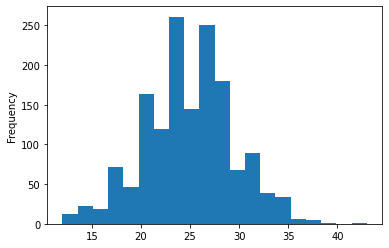

In [12]:
users_go['age'].plot(kind='hist', bins=20)

In [13]:
users_go['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [14]:
users_go['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

В таблице "users_go" все чисто.

In [15]:
#Изучим таблицу rides_go
rides_go.describe()

,user_id,distance,duration
count,"18,068.00","18,068.00","18,068.00"
mean,842.87,"3,070.66",17.81
std,434.73,"1,116.83",6.09
min,1.00,0.86,0.50
25%,487.00,"2,543.23",13.60
50%,889.00,"3,133.61",17.68
75%,"1,213.25","3,776.22",21.72
max,"1,534.00","7,211.01",40.82


In [16]:
rides_go['date'].describe()

/tmp/ipykernel_78/3394252612.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  rides_go['date'].describe()


count                   18068
unique                    364
top       2021-12-22 00:00:00
freq                       72
first     2021-01-01 00:00:00
last      2021-12-30 00:00:00
Name: date, dtype: object

In [17]:
# создадим столбец month - номер месяца на основе столбца date
rides_go['month']=rides_go['date'].dt.month

Таблица "rides_go" без аномалий и дубликатов

In [18]:
# Изучим таблицу subscriptions_go
subscriptions_go.describe()

,minute_price,start_ride_price,subscription_fee
count,2.00,2.00,2.00
mean,7.00,25.00,99.50
std,1.41,35.36,140.71
min,6.00,0.00,0.00
25%,6.50,12.50,49.75
50%,7.00,25.00,99.50
75%,7.50,37.50,149.25
max,8.00,50.00,199.00


In [19]:
subscriptions_go['subscription_type'].unique()

array(['free', 'ultra'], dtype=object)

**Вывод:** Предобработка данных практически не потребовалась. Данные без аномалий и без неявных дубликатов.
Данные представлены за 2021 год.

#### Шаг 3. Исследовательский анализ данных

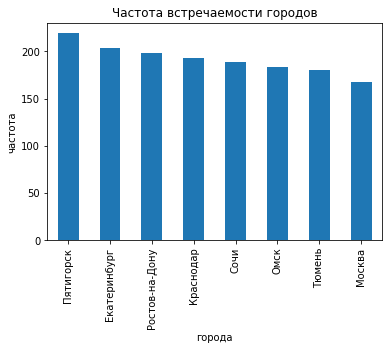

In [20]:
# Изучим частоту встречаемости городов
users_go['city'].value_counts().plot.bar()
plt.title('Частота встречаемости городов')
plt.xlabel('города')
plt.ylabel('частота')
plt.show()

Больше всего клиентов из Пятигорска(чуть больше 200), а меньше всего - из Москвы (около 170).

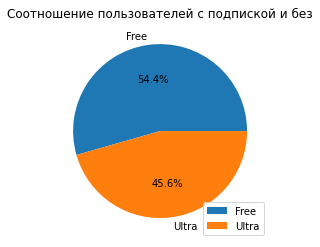

In [21]:
# Изучим соотношение пользователей с подпиской и без
#users_go['subscription_type'].value_counts(normalize=True).plot.pie()
labels = ['Free', 'Ultra']
plt.pie(users_go['subscription_type'].value_counts(normalize=True), labels=labels,autopct='%.1f%%')
plt.title('Соотношение пользователей с подпиской и без')
plt.legend(loc='lower right')

plt.show()

In [22]:
users_go['subscription_type'].value_counts(normalize=True)

free    0.54
ultra   0.46
Name: subscription_type, dtype: float64

In [23]:
# Изучим соотношение пользователей с подпиской и без в разрезе городов
data_pivot=pd.pivot_table(users_go, index=['city', 'subscription_type'], values=['user_id'], aggfunc='count')
data_pivot['%_value']=data_pivot['user_id']/pd.pivot_table(users_go, index=['city'], values=['user_id'], aggfunc='count')['user_id']
data_pivot

user_id  %_value
city           subscription_type                  
Екатеринбург   free                   112     0.55
               ultra                   92     0.45
Краснодар      free                   112     0.58
               ultra                   81     0.42
Москва         free                    84     0.50
               ultra                   84     0.50
Омск           free                    92     0.50
               ultra                   91     0.50
Пятигорск      free                   125     0.57
               ultra                   94     0.43
Ростов-на-Дону free                   109     0.55
               ultra                   89     0.45
Сочи           free                   103     0.54
               ultra                   86     0.46
Тюмень         free                    98     0.54
               ultra                   82     0.46

Пользователей с подпиской явно меньше, чем без. Число таких пользователей не превышает 50%

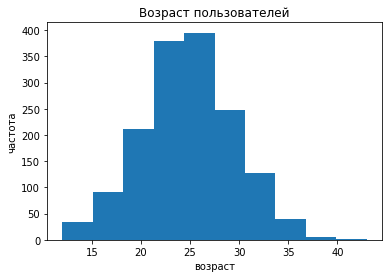

In [24]:
# Изучим возраст пользователей
users_go['age'].plot.hist()
plt.title('Возраст пользователей')
plt.xlabel('возраст')
plt.ylabel('частота')
plt.show()

In [25]:
users_go['age'].describe()

count   1,534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

Гистограмма возраста пользователей имеет нормальное распределение. Средний возраст клиентов - 25 лет.

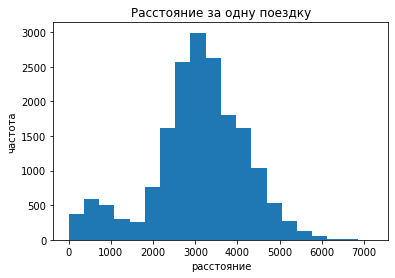

In [26]:
# Изучим расстояние, которое проехал пользователь за 1 поездку
rides_go['distance'].plot.hist(bins=20)
plt.title('Расстояние за одну поездку')
plt.xlabel('расстояние')
plt.ylabel('частота')
plt.show()

In [27]:
rides_go['distance'].describe()

count   18,068.00
mean     3,070.66
std      1,116.83
min          0.86
25%      2,543.23
50%      3,133.61
75%      3,776.22
max      7,211.01
Name: distance, dtype: float64

В среднем пользователи ездят 3,2 км.
Есть небольшой "колокол" в районе 0-1000 м. Я думаю, что это связано с тем, что есть 2 стратегии пользования самокатами:
1) Человек пользуются самокатом в дополнение к основному виду транспорта, когда нужно быстро добраться до пункта назначения (в пределах 1 км), возможно от ближайшей остановки до пункта назначения.<br>
2) Человек полностью заменил средство передвижения на самокат, поэтому средняя дистанция поездки 3 км и выше.

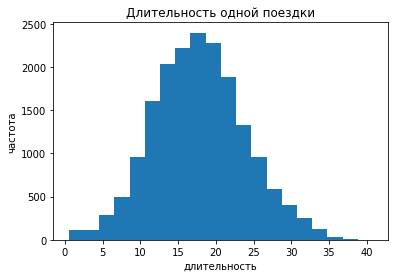

In [28]:
# Изучим продолжительность поездок
rides_go['duration'].plot.hist(bins=20)
plt.title('Длительность одной поездки')
plt.xlabel('длительность')
plt.ylabel('частота')
plt.show()

In [29]:
rides_go['duration'].describe()

count   18,068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: float64

В основном длительность одной поездки в районе 15-20 мин.

**Вывод:**
Больше всего клиентов из Пятигорска, а меньше всего - из Москвы.<br>
Пользователей без подписки больше(54%), чем с подпиской (46%)<br>
Средний возраст клиентов 25 лет, самый младший клиент - 12 лет, старший - 43 года<br>
Средняя дистанция одной поездки чуть больше 3 км, минимальная - около 90 м, наибольшая - около 7 км <br>
Средняя продолжительность поездки - около 18 мин, минимальная около минуты, самая длинная - около 41 минуты.

#### Шаг 4. Объединение данных

In [30]:
# Объединим данные о пользователях, поездках и подписках
data=users_go.merge(rides_go, on='user_id')
data=data.merge(subscriptions_go, on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.92",25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.59",15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.78",18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.69",26.27,2021-08-28,8,6,0,199


In [31]:
# Сравним кол-во строк после обьединения и до
data.shape

(18068, 12)

Кол-во строк после обьединения и до совпадает, значит мы не потеряли информацию при обьеденени.

In [32]:
# Создадим 2 датасета с информацией о пользователях с подпиской и без
data_ultra=data[data['subscription_type']=='ultra']
display(data_ultra.head())
print(data_ultra.shape)
data_free=data[data['subscription_type']=='free']
display(data_free.head())
print(data_free.shape)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,"4,409.92",25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.59",15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.78",18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.69",26.27,2021-08-28,8,6,0,199


(6500, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,"2,515.69",14.94,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.23,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,"4,004.43",20.02,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,"1,205.91",9.78,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,"3,047.38",17.43,2021-02-14,2,8,50,0


(11568, 12)


В разделе 3 мы выяснили, что пользователей с подпиской 46%, а без - 54%. Однако здесь мы видим, что таблица с информацией о пользователях с подпиской практически в 2 раза меньше, чем таблица с информацией о пользователях без подписки. Я думаю, это связано с тем, что в среднем один пользователь с подпиской реже пользуется самокатом, нежели чем один пользователь без подписки

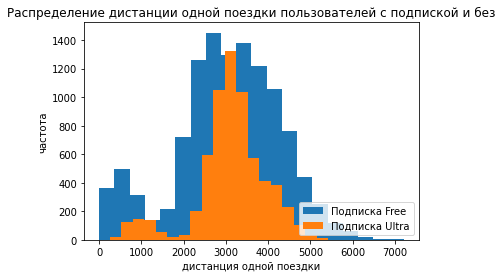

In [33]:
# Визуализируем распределение дистанции одной поездки в зависимости от наличия подписки
data_free['distance'].plot.hist(bins=20)
data_ultra['distance'].plot.hist(bins=20)
plt.title('Распределение дистанции одной поездки пользователей с подпиской и без')
plt.xlabel('дистанция одной поездки')
plt.ylabel('частота')
plt.legend(['Подписка Free', 'Подписка Ultra'],loc='lower right')
plt.show()

У пользователей с подпиской средняя дистанция одной поездки в районе 3 км, у пользователей без подписки - от 2,5 до 3,5 км.
Коротких поездок до 1 км у пользователей без подписки явно больше в несколько раз, чем к пользователей с подпиской. Это может быть обьяснено еще и тем, что прежде чем оформить подписку пользователи обычно тестируют продукт.

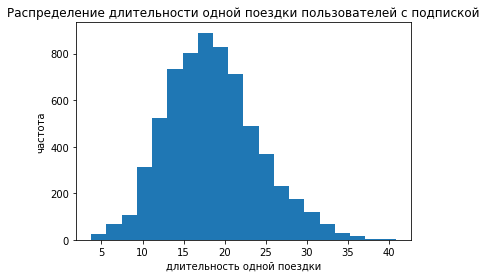

In [34]:
# Визуализируем распределение длительности одной поездки в зависимости от наличия подписки
data_ultra['duration'].plot.hist(bins=20)
plt.title('Распределение длительности одной поездки пользователей с подпиской')
plt.xlabel('длительность одной поездки')
plt.ylabel('частота')
plt.show()

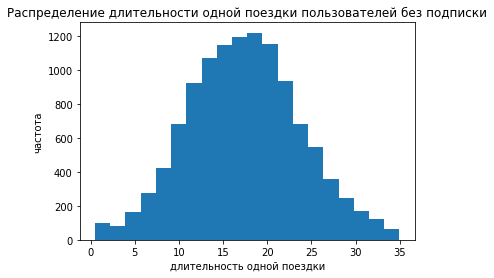

In [35]:
data_free['duration'].plot.hist(bins=20)
plt.title('Распределение длительности одной поездки пользователей без подписки')
plt.xlabel('длительность одной поездки')
plt.ylabel('частота')
plt.show()

Распределение длительности поездок коррелирует сдистанцией поездок. Среднее время, которое пользователь с подпиской трати на поездку - примерно 17 мин. А пользователь без подписки - 15-20 мин

#### Шаг 5. Подсчёт выручки

In [36]:
# найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
# Для пользователей с подпиской
# Для начала округлим длительность поездки до целого числа в большую сторону
data_ultra['duration']=data_ultra['duration'].apply(np.ceil)
data_pivot_ultra=pd.pivot_table(data_ultra, index=['user_id','month'], values=['distance', 'duration', 'minute_price','start_ride_price','subscription_fee'], aggfunc={'distance':'count', 'duration':'sum','minute_price':'mean','start_ride_price':'mean','subscription_fee':'mean'})
data_pivot_ultra=data_pivot_ultra.rename(columns={'distance':'trip_number', 'duration':'total_trip_duration'})
data_pivot_ultra['subscription_type']='ultra'
data_pivot_ultra.head(15)

/tmp/ipykernel_78/2374444555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ultra['duration']=data_ultra['duration'].apply(np.ceil)


trip_number  total_trip_duration  minute_price  \
user_id month                                                   
1       1                2                42.00             6   
        4                1                 7.00             6   
        8                2                46.00             6   
        10               2                32.00             6   
        11               3                56.00             6   
        12               2                28.00             6   
2       3                3                63.00             6   
        4                2                40.00             6   
        6                1                14.00             6   
        7                2                48.00             6   
        8                1                 7.00             6   
        10               1                19.00             6   
        12               1                12.00             6   
3       1                1                13.00             6   
        2                2                39.00             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra  
        12                    0               199             ultra  
2       3                     0               199             ultra  
        4                     0               199             ultra  
        6                     0               199             ultra  
        7                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        12                    0               199             ultra  
3       1                     0               199             ultra  
        2                     0               199             ultra

In [37]:
# Для начала округлим длительность поездки до целого числа в большую сторону
data_free['duration']=data_free['duration'].apply(np.ceil)
# Для пользователей без подписки
data_pivot_free=pd.pivot_table(data_free, index=['user_id','month'], values=['distance', 'duration', 'minute_price','start_ride_price','subscription_fee'], aggfunc={'distance':'count', 'duration':'sum','minute_price':'mean','start_ride_price':'mean','subscription_fee':'mean'})
data_pivot_free=data_pivot_free.rename(columns={'distance':'trip_number', 'duration':'total_trip_duration'})
data_pivot_free['subscription_type']='free'
data_pivot_free.head(15)

/tmp/ipykernel_78/3878803993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_free['duration']=data_free['duration'].apply(np.ceil)


trip_number  total_trip_duration  minute_price  \
user_id month                                                   
700     1                1                15.00             8   
        2                5                89.00             8   
        3                1                19.00             8   
        4                1                16.00             8   
        6                2                29.00             8   
        7                2                21.00             8   
        8                1                17.00             8   
        10               2                44.00             8   
        11               3                32.00             8   
701     1                1                18.00             8   
        2                2                27.00             8   
        3                1                17.00             8   
        4                1                14.00             8   
        5                1                15.00             8   
        6                2                26.00             8   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
700     1                    50                 0              free  
        2                    50                 0              free  
        3                    50                 0              free  
        4                    50                 0              free  
        6                    50                 0              free  
        7                    50                 0              free  
        8                    50                 0              free  
        10                   50                 0              free  
        11                   50                 0              free  
701     1                    50                 0              free  
        2                    50                 0              free  
        3                    50                 0              free  
        4                    50                 0              free  
        5                    50                 0              free  
        6                    50                 0              free

In [38]:
# добавим столбец с помесячной выручкой, которую принёс каждый пользователь.
# Для пользователей с подпиской
data_pivot_ultra['revenue']=data_pivot_ultra['trip_number']*data_pivot_ultra['start_ride_price']+data_pivot_ultra['total_trip_duration']*data_pivot_ultra['minute_price']+data_pivot_ultra['subscription_fee']
data_pivot_ultra.head()

trip_number  total_trip_duration  minute_price  \
user_id month                                                   
1       1                2                42.00             6   
        4                1                 7.00             6   
        8                2                46.00             6   
        10               2                32.00             6   
        11               3                56.00             6   

               start_ride_price  subscription_fee subscription_type  revenue  
user_id month                                                                 
1       1                     0               199             ultra   451.00  
        4                     0               199             ultra   241.00  
        8                     0               199             ultra   475.00  
        10                    0               199             ultra   391.00  
        11                    0               199             ultra   535.00

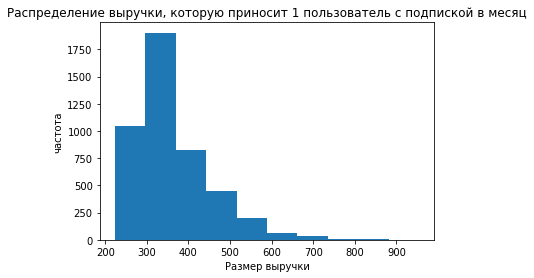

In [39]:
data_pivot_ultra['revenue'].plot.hist()
plt.title('Распределение выручки, которую приносит 1 пользователь с подпиской в месяц')
plt.xlabel('Размер выручки')
plt.ylabel('частота')
plt.show()

In [40]:
data_pivot_ultra['revenue'].describe()

count   4,533.00
mean      362.79
std        88.26
min       223.00
25%       301.00
50%       337.00
75%       409.00
max       955.00
Name: revenue, dtype: float64

In [41]:
# Для пользователей без подписки
data_pivot_free['revenue']=data_pivot_free['trip_number']*data_pivot_free['start_ride_price']+data_pivot_free['total_trip_duration']*data_pivot_free['minute_price']+data_pivot_free['subscription_fee']
data_pivot_free.head()

trip_number  total_trip_duration  minute_price  \
user_id month                                                   
700     1                1                15.00             8   
        2                5                89.00             8   
        3                1                19.00             8   
        4                1                16.00             8   
        6                2                29.00             8   

               start_ride_price  subscription_fee subscription_type  revenue  
user_id month                                                                 
700     1                    50                 0              free   170.00  
        2                    50                 0              free   962.00  
        3                    50                 0              free   202.00  
        4                    50                 0              free   178.00  
        6                    50                 0              free   332.00

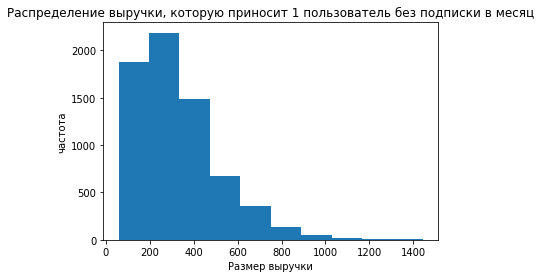

In [42]:
data_pivot_free['revenue'].plot.hist()
plt.title('Распределение выручки, которую приносит 1 пользователь без подписки в месяц')
plt.xlabel('Размер выручки')
plt.ylabel('частота')
plt.show()

In [43]:
data_pivot_free['revenue'].describe()

count   6,798.00
mean      328.64
std       183.87
min        58.00
25%       194.00
50%       274.00
75%       428.00
max     1,444.00
Name: revenue, dtype: float64

Как показывают графики и описание, в среднем пользователи с подпиской приносят бОльшую месячную выручку, чем пользователи без подписок.
В таблицы с информацией о пользователях с подпиской и без были добавлены столбцы: Кол-во поездок, Суммарная длительность поездок, выручка в разрезе каждого пользователя и каждого месяца.
В следующей главе будем проверять гипотезы.

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. <br>
H0: время, затраченное пользователем с подпиской на поездку = время, затраченное пользователем без подписки на поездку <br>
H1: время, затраченное пользователем с подпиской на поездку > время, затраченное пользователем без подписки на поездку

У нас есть 2 генеральные совокупности: таблицы с информацией о пользователях с подпиской и без. Уровень значимости установим 0,05. Будем использовать критерий Стьюдента для двух независимых выборок.

In [44]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater', equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


In [45]:
# Выведем средние продолжительности поездок для каждой категории пользовавтелей
print('Средняя продолжительность поездки пользователя с подпиской', data_ultra['duration'].mean())
print('Средняя продолжительность поездки пользователя без подписки', data_free['duration'].mean())

Средняя продолжительность поездки пользователя с подпиской 19.037692307692307
Средняя продолжительность поездки пользователя без подписки 17.890992392807746


Вывод: Полученное значение p-value (~1.1814679253701353e-36) крайне мало и меньше заданного уровня значимости, поэтому мы  отвергаем нулевую гипотезу. Видимо пользователи с подпиской действительно тратят времени в среднем больше, чем пользователи без подписки.<br>
Средние значения так же подтверждают правильность результатов теста.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

H0:μ=3130 (среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров) <br>
H1:μ>3130 (среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров) <br>
Это проверка односторонней гипотезы о равенстве среднего генеральной совокупности. Будем использовать t-тест.
Уровень значимости установим 0,05.

In [46]:
interested_value = 3130 # такую дистанцию в среднем

alpha = 0.05 # уровень статистической значимости
            # можно указать .05 или 0.05

results = st.ttest_1samp(
    data_ultra['distance'], 
    interested_value, alternative='greater' )

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Вывод: Полученное значение p-value (~0.9195368847849785) больше заданного уровня значимости, поэтому мы не можем отвергнуть нулевую гипотезу. Видимо пользователи с подпиской действительно проезжают в среднем не больше 3130 м.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. <br>
H0: помесячная выручка от пользователей с подпиской по месяцам = помесячная выручка от пользователей без подписки по месяцам <br>
H1: помесячная выручка от пользователей с подпиской по месяцам > помесячная выручка от пользователей без подписки по месяцам

У нас есть 2 генеральные совокупности: таблицы с информацией о пользователях с подпиской и без. Уровень значимости установим 0,05. Будем использовать критерий Стьюдента для двух независимых выборок.

In [47]:
# задаём уровень значимости
alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data_pivot_ultra['revenue'], data_pivot_free['revenue'], alternative='greater', equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Вывод: Полученное значение p-value (~8.874140893976874e-40) меньше заданного уровня значимости, поэтому мы не можем принять нулевую гипотезу. Видимо пользователи с подпиской приносят в среднем большую выручку, чем пользователи без подписки.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки этой гипотезы нужно и спользовать t критерий Стьюдента для зависимых (парных) выборок (односторонняя гипотеза (меньше)). Нужно использовать метод scipy.stats.ttest_rel().

**Вывод:** мы проверили несколько гипотез и установили:<br>
Вероятно пользователи с подпиской тратят времени на поездки в среднем больше, чем пользователи без подписки.<br>
Вероятно пользователи с подпиской действительно проезжают в среднем не больше 3130 м.<br>
Вероятно пользователи с подпиской приносят в среднем большую выручку, чем пользователи без подписки.<br>
Для проверки односторонних гипотез я использовала t критерий Стьюдента для независимых выборок, а также t тест для проверки равенства среднего генеральной совокупности.

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

В этой задаче нам предстоит работать с биноминальным распределением, так как у нас всего 2 исхода: либо продление подписки (успех), либо отказ от нее (неудача.) <br>
Предположение: на первый взгляд кажется, что нужно разослать промокод около 1000 клиентов. Посмотрим на это предположение на графике биноминального распределения.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 1000 artists>

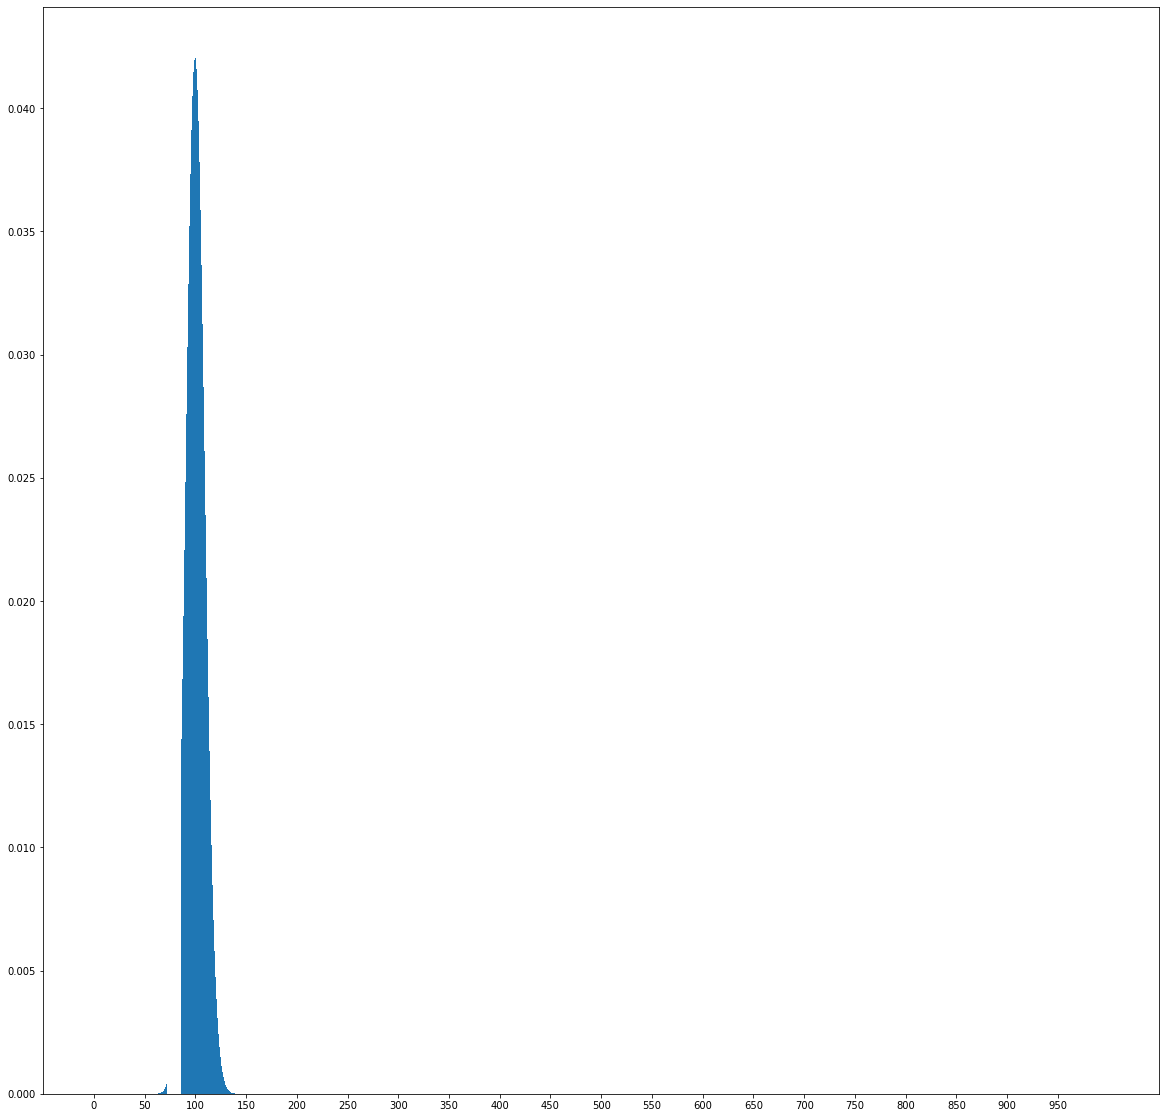

In [48]:
n = 1000
# количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
plt.figure(figsize=(20,20))
plt.xticks(np.arange(0, 1000, 50))     
plt.bar(range(0, n), distr)

Судя по графику, вероятность неудачи(привлечь менее 100 клиентов) при отправке в 1000 промокодов явно больше 5%. Рассчитаем точный % вероятности.

In [49]:
# задаём параметры биномиального распределения для вычисления вероятность с помощью метода binom.cdf
# зададим размер выборки клиентов (общее число испытаний). Это наше искомое число
n = 1000
# Зададим вероятность успеха
p = 0.1
# Зададим ожидаемое число привлеченных пользователей (успешных испытаний)
k=100

# считаем вероятность привлечь 100 и менее клиентов при охвате 1000 клиентов
result = st.binom.cdf(k, n, p)
print(result)


0.5265990812951653


Вероятность привлечь менее 100 клиентов очень большая = 50%. А по условию задачи нам нужно получить вероятность 5%. Значит охват в 1000 клиентов нам не подходит. Будем подбирать параметры.

In [50]:
# Запустим цикл для подбора параметра n  - кол-во промокодов, которое нужно разослать, чтобы привлечь не менее 100 клиентов, при этом вероятность не выполнить план 5%.
distr=[]

for n in range(900, 1200):
    result=st.binom.cdf(k, n, p)
    if result<=0.05:
        print(n)
        break

1172


Методом подбора получилось найти приблизительное кол-во промокодов, которое необходимо отправить, чтобы вероятность не выполнить план была примерно 5 %. Это число 1172.

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Эту задачу тоже буду решать с помощью аппроксимации биноминального распределения нормальным. Нам нужно найти

In [51]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4
interested_value=399500
# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 


# считаем вероятность, что уведомление откроют не более 399500 клиентов
result = distr.cdf(interested_value)
print(result)

0.15371708296369768


Вероятность того, что уведомление откроют не более 399500 пользователей около 15%.

#### Общий вывод

В данном проекте было проведено исследование пользователей с подписками и без сервиса аренды самокатов GoFast , а также их поездок. 
Предобработка данных практически не потребовалась. Данные без аномалий и без неявных дубликатов.
Данные представлены за 2021 год. Первичная информация была представлена в 3 таблицах: информация о пользователях, поездках и типах подписок. Для дальнейшего исследования таблицы были обьеденины и разделены по категориям пользователей: с подпиской(6500 записей) и без(11568 записей).
В ходе анализа было выяснено: <br>
Больше всего клиентов из Пятигорска(чуть больше 200), а меньше всего - из Москвы (около 170).<br>
Пользователей без подписки больше(54%), чем с подпиской (46%)<br>
Средний возраст клиентов 25 лет, самый младший клиент - 12 лет, старший - 43 года<br>
Средняя дистанция одной поездки чуть больше 3 км, минимальная - около 90 м, наибольшая - около 7 км <br>
Средняя продолжительность поездки - около 18 мин, минимальная около минуты, самая длинная - около 41 минуты.

Были проверены несколько гипотез и статистика показала, что: 
- Вероятно пользователи с подпиской тратят времени на поездки в среднем больше, чем пользователи без подписки.<br>
- Вероятно пользователи с подпиской действительно проезжают в среднем не больше 3130 м.<br>
- Вероятно пользователи с подпиской приносят в среднем большую выручку, чем пользователи без подписки.<br>
Для проверки односторонних гипотез я использовала t критерий Стьюдента для независимых выборок (1 и 3 гипотезы), а также t тест для проверки равенства среднего генеральной совокупности (2 гипотеза).

Также, было найдено кол-во промокодов на пробную подписку, которое необходимо разослать клиентам, чтобы как минимум 100 клиентов продлили подписку после пробного периода. При этом вероятность не выполнить план должна быть примерно 5 %. Было получено число 1172. <br>
Была рассчитана вероятность, что не более 399500 пользователей откроют push-уведомления от сервиса при условии, что всего планируется разослать 1 млн уведомлений, а вероятность успеха 40%. Вероятность получилась около 15%.